## PyTorch Custom Datasets

## 0. Import PyTorch & Setting Up Device-Agnostic Code

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time
import torch
import random
import requests
import zipfile
import pathlib
import torchinfo
import torchvision
import numpy as np
import pandas as pd

from torch import nn
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from torchinfo import summary
from matplotlib import pyplot as plt
from typing import Tuple, Dict, List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/UygarKAYA/DeepLearning/main/utils/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  
from helper_functions import accuracy_func
from helper_functions import execution_time

In [4]:
# Setup Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data from GitHub

 * Our Dataset is a Subset of the Food101 Dataset.
 * Food101 Starts 101 Different Classes of Food and 1000 Images Per Class (750 Training, 250 Testing).
 * Our Dataset Starts with 3 Classes of Food and Only 10% of the Images (~75 Training, 25 Testing).

In [5]:
data_path = Path("data/food101_dataset")
zip_data_path = 'data/food101_dataset.zip'

if data_path.is_dir():
  print(f"{data_path} directory already exist... skipping download")
else:
  print(f"{data_path} does not exist, creating one...")
  data_path.mkdir(parents=True, exist_ok=True)

# Download Food101 Dataset from GitHub Repository
with open(zip_data_path, 'wb') as f:
  request = requests.get('https://github.com/UygarKAYA/DeepLearning/raw/main/data/food101_dataset.zip')
  f.write(request.content)

# Unzip Food101 Dataset
with zipfile.ZipFile(zip_data_path, 'r') as zip:
  zip.extractall(data_path)

data/food101_dataset does not exist, creating one...


## 2. Data Preparation

In [6]:
# Setup Train and Testing Paths
train_path = data_path/'train'
test_path = data_path/'test'

# Write a Transform for Image
data_transform = transforms.Compose([
    # Resize Our Images to 64x64
    transforms.Resize(size=(64, 64)),

    # Flip the Images Randomly on the Horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # Turn the Image into torch.Tensor
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_path,
                                 transform=data_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food101_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food101_dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [7]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 2.1 Prepare DataLoader

In [8]:
# Setup the Batch Size Hyperparameter
BATCH_SIZE=32
SHUFFLE_TRAIN_DATASET=True
SHUFFLE_TEST_DATASET=False

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, 
                              shuffle=SHUFFLE_TRAIN_DATASET)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=SHUFFLE_TEST_DATASET)


# Let's check out what what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")     

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f642fe3fa90>, <torch.utils.data.dataloader.DataLoader object at 0x7f642fe3ff10>)
Length of train_dataloader: 8 batches of 32...
Length of test_dataloader: 3 batches of 32...


## 2.2 Option 1: Loading Image Data with a Custom Dataset

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
  * Can create a Dataset out of almost anything
  * Not limited to PyTorch pre-built Dataset functions

Cons:
* Even though you could create Dataset out of almost anything, it doesn't mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors or performance issues


## 2.2.1 Creating a Helper Function to Get Class Names

In [9]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the Class Folder Names in a Target Directory."""
  # 1. Get the class names by scanning the target directory
  class_names = sorted(class_.name for class_ in os.scandir(directory) if class_.is_dir())

  # 2. Raise an error if class names could not be found
  if not class_names:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
  
  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

  return class_names, class_to_idx

# 2.2.2 Create a Custom Dataset to Replicate ImageFolder

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd like to use
* classes - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [10]:
# 1. Subclass torch.utils.data.Dataset
class CustomImageFolder(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, 
               targ_dir: str, 
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
  
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [11]:
train_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [12]:
# Test out CustomImageFolder

custom_train_data = CustomImageFolder(targ_dir=train_path,
                                      transform=train_data_transform)

custom_test_data = CustomImageFolder(targ_dir=test_path,
                                     transform=test_data_transform)

custom_train_data, custom_test_data

(<__main__.CustomImageFolder at 0x7f642fe3f340>,
 <__main__.CustomImageFolder at 0x7f642fe3f640>)

## 2.3 Create a Helper Function to Display Random Images

1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)



In [13]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=False,
                          seed: int=None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for idx, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, idx+1)
    plt.imshow(targ_image_adjust)
    if classes:
      title = f"{classes[targ_label]}"
      if display_shape:
        title = title + f"\n{targ_image_adjust.shape}"
    plt.title(title) 

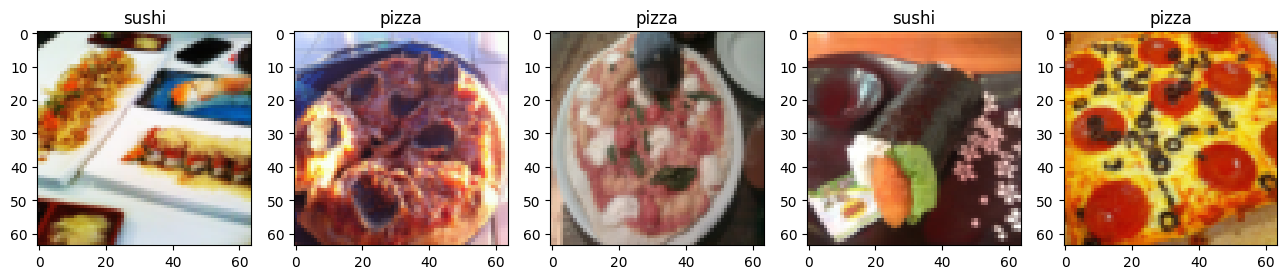

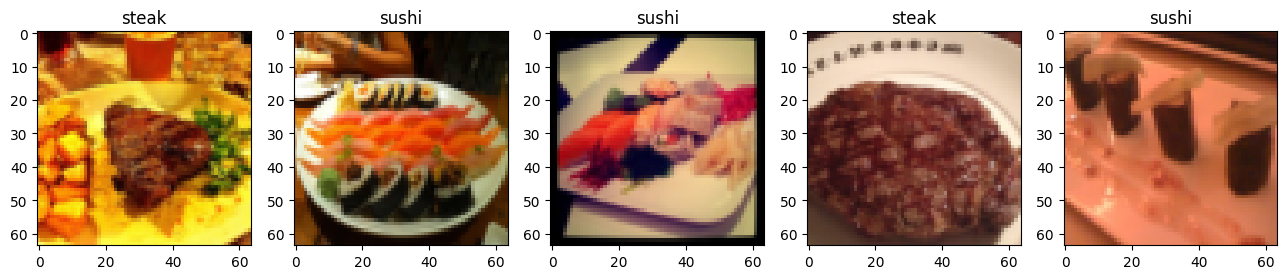

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5, 
                      classes=class_names,
                      seed=42)

# Display random images from the ImageFolderCustom Dataset
display_random_images(custom_train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

## 2.4 Turn Custom Loaded Images Into DataLoader's

In [14]:
# Setup the Batch Size Hyperparameter
BATCH_SIZE=1
SHUFFLE_TRAIN_DATASET=True
SHUFFLE_TEST_DATASET=False

custom_train_dataloader = DataLoader(dataset=custom_train_data,
                                     batch_size=BATCH_SIZE,
                                     shuffle=SHUFFLE_TRAIN_DATASET)

custom_test_dataloader = DataLoader(dataset=custom_test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=SHUFFLE_TEST_DATASET)

custom_train_dataloader, custom_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f642fe3fa00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f642801baf0>)

## 3. Other Forms of Transforms (Data Augmentation)

1. Data augmentation is the process of artificially adding diversity to your training data.

2. In the case of image data, this may mean applying various image transformations to the training images.

3. This practice hopefully results in a model that's more generalizable to unseen data.

4. Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

## 3.1 Create Transform and Train & Test Dataset's with Data Augmentation

In [15]:
train_transform_data_aug = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_data_aug = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_augmented = datasets.ImageFolder(root=train_path,
                                            transform=train_transform_data_aug)

test_data_augmented = datasets.ImageFolder(root=test_path,
                                           transform=test_transform_data_aug)


# Setup the Batch Size Hyperparameter for DataLoader
BATCH_SIZE=1
SHUFFLE_TRAIN_DATASET=True
SHUFFLE_TEST_DATASET=False

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=SHUFFLE_TRAIN_DATASET)

test_dataloader_augmented = DataLoader(dataset=test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=SHUFFLE_TEST_DATASET)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7f64377c0250>,
 <torch.utils.data.dataloader.DataLoader at 0x7f64377c0940>)

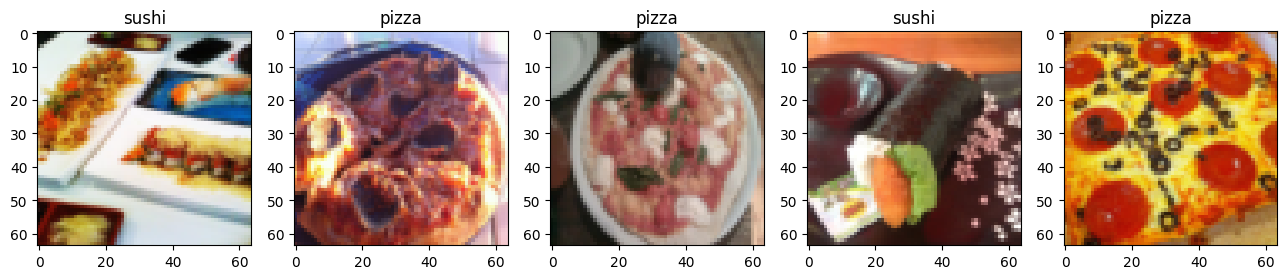

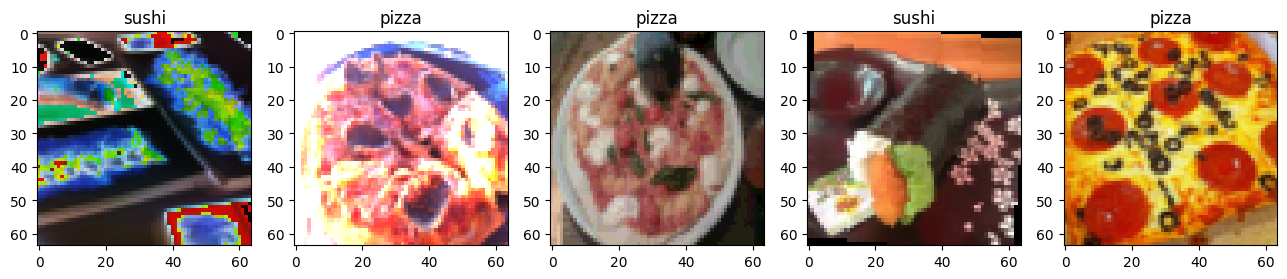

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5, 
                      classes=class_names,
                      seed=42)

# Display random images from the Dataset with Data Augmentation
display_random_images(train_data_augmented,
                      n=5,
                      classes=class_names,
                      seed=42)

## 4. ModelV0: TinyVGG without Data Augmentation

In [16]:
from torch.nn.modules.pooling import MaxPool2d
# Create a Convolutional Neural Network - ConvNets
# Setup Hyperparameters
KERNEL_SIZE=3
STRIDE=1
PADDING=0

class TinyVGG(nn.Module):
  """
  Model Architecture that Replicates the TinyVGG Model from images/ConvNets.png
  """
  def __init__(self, 
               input_channels: int,
               input_shape: int, 
               hidden_neurons: int,
               output_shape: int):
    super().__init__()
    self.first_conv_block = nn.Sequential(
        nn.Conv2d(in_channels=input_channels,
                  out_channels=hidden_neurons,
                  kernel_size=KERNEL_SIZE,
                  stride=STRIDE,
                  padding=PADDING),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_neurons,
                  out_channels=hidden_neurons,
                  kernel_size=KERNEL_SIZE,
                  stride=STRIDE,
                  padding=PADDING),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(KERNEL_SIZE-1))
    )
    self.second_conv_block = nn.Sequential(
        nn.Conv2d(in_channels=hidden_neurons,
                  out_channels=hidden_neurons,
                  kernel_size=KERNEL_SIZE,
                  stride=STRIDE,
                  padding=PADDING),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_neurons,
                  out_channels=hidden_neurons,
                  kernel_size=KERNEL_SIZE,
                  stride=STRIDE,
                  padding=PADDING),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(KERNEL_SIZE-1))
    )
    self.fully_connected_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_neurons*input_shape,
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.fully_connected_layer(self.second_conv_block(self.first_conv_block(x)))

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create an Instance of TinyVGG
convNetsModelV0 = TinyVGG(
    input_channels=3, # number of color channels in our image data
    input_shape=13*13,
    hidden_neurons=10,
    output_shape=len(class_names)
).to(device)

## 4.1 Use `torchinfo` to Get an Idea of the Shapes Going Through Our Model

In [18]:
summary(convNetsModelV0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## 4.2 Functionizing Training & Testing/Inference Loops

In [19]:
# Create Training Step
def train_model(model: torch.nn.Module,
                train_data_loader: torch.utils.data.DataLoader, 
                loss_func: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_func,
                device: torch.device=device):
  """
  Performs a Training with Model Trying to Learn on DataLoader
  """
  
  train_loss, train_accuracy = 0, 0

  # Put Model into Training Phase
  model.train()

  # Add a Loop to Loop Through the Training Batches
  for batch, (train_image, train_label) in enumerate(train_data_loader):
    
    # Put Data to Target Device
    train_image, train_label = train_image.to(device), train_label.to(device)
    
    # 1. Forward Pass
    train_logits = model.forward(train_image)
    train_preds = torch.argmax(torch.softmax(train_logits, dim=1), dim=1)

    # 2. Calculate Loss & Accuracy Per Batch
    train_loss_ = loss_func(train_logits, train_label)
    train_loss += train_loss_.item() #  Accumulate Train Loss
    train_accuracy += accuracy_func(train_preds, train_label)

    # 3. Optimizer Zero Grad
    optimizer.zero_grad()

    # 4. Loss Backward
    train_loss_.backward()

    # 5. Optimizer Step
    optimizer.step()

  # Divide Total Train Loss & Accuracy by Length of Train DataLoader
  train_loss /= len(train_data_loader)
  train_accuracy /= len(train_data_loader)

  # print(f"Train Accuracy: {train_accuracy:.2f} | Train Loss: {train_loss:.2f}")
  return train_loss, train_accuracy

In [20]:
# Create Testing Step
def test_model(model: torch.nn.Module,
               test_data_loader: torch.utils.data.DataLoader,
               loss_func: torch.nn.Module, 
               accuracy_func,
               device: torch.device=device):
  """
  Performs a Testing Loop Step on Model Going Over DataLoader
  """

  test_loss, test_accuracy = 0, 0

  # Put the Model in Eval Mode
  model.eval()

  # Turn on Inference Mode Context Manager
  with torch.inference_mode():
    for batch, (test_image, test_label) in enumerate(test_data_loader):

      # Send the Data Target Device
      test_image, test_label = test_image.to(device), test_label.to(device)

      # 1. Forward Pass
      test_logits = model.forward(test_image)
      test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

      # 2. Calculate Loss & Accuracy Per Batch
      test_loss += loss_func(test_logits, test_label).item()
      test_accuracy += accuracy_func(test_preds, test_label)

    # Divide Total Test Loss & Accuracy by Length of Test DataLoader
    test_loss /= len(test_data_loader)
    test_accuracy /= len(test_data_loader)
  
    # print(f"Test Accuracy:  {test_accuracy:.2f} | Test Loss:  {test_loss:.2f}")
    return test_loss, test_accuracy

In [21]:
def train_step(model: torch.nn.Module,
               epochs: int, 
               train_data: torch.utils.data.DataLoader,
               test_data: torch.utils.data.DataLoader,
               loss_func: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_func,
               device: torch.device=device):

  # Create empty results dictionary for plotting the model result
  model_results_dict = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

  for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = train_model(model=model,
                                            train_data_loader=train_data,
                                            loss_func=loss_func,
                                            optimizer=optimizer,
                                            accuracy_func=accuracy_func,
                                            device=device)
    
    test_loss, test_accuracy = test_model(model=model,
                                          test_data_loader=test_data,
                                          loss_func=loss_func,
                                          accuracy_func=accuracy_func,
                                          device=device)
    
    print(f"Epoch: {epoch} | Train Accuracy: {train_accuracy:.2f} | Train Loss: {train_loss:.2f} | Test Accuracy:  {test_accuracy:.2f} | Test Loss:  {test_loss:.2f}")

    # 5. Update results dictionary
    model_results_dict["train_loss"].append(train_loss)
    model_results_dict["train_accuracy"].append(train_accuracy)
    model_results_dict["test_loss"].append(test_loss)
    model_results_dict["test_accuracy"].append(test_accuracy)
  
  return model_results_dict

## 4.4 Create Loss Function, Optimizer & Evaluation Function

In [22]:
# Setup Random Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate an Instance of TinyVGG
convNetsModelV0 = TinyVGG(
    input_channels=3, # number of color channels in our image data
    input_shape=13*13,
    hidden_neurons=10,
    output_shape=len(class_names)
).to(device)

# Setup Hyperparameter
EPOCHS=15
LEARNING_RATE=0.001
MODEL_PARAMETERS=convNetsModelV0.parameters()

# Setup Loss Function & Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=MODEL_PARAMETERS,
                             lr=LEARNING_RATE)

# Start the Timer
execution_start_time = time.time()

# Train First TinyVGG Model
convNetsModelV0Result = train_step(model=convNetsModelV0,
                                   epochs=EPOCHS,
                                   train_data=train_dataloader,
                                   test_data=test_dataloader,
                                   loss_func=loss_func,
                                   optimizer=optimizer,
                                   accuracy_func=accuracy_func,
                                   device=device)

# End the Timer & Print Out How Long It Took
execution_end_time = time.time()
model_execution_time = execution_time(
  start_time=execution_start_time,
  end_time=execution_end_time,
  device=device
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train Accuracy: 30.86 | Train Loss: 1.11 | Test Accuracy:  22.92 | Test Loss:  1.10
Epoch: 1 | Train Accuracy: 28.91 | Train Loss: 1.11 | Test Accuracy:  54.17 | Test Loss:  1.07
Epoch: 2 | Train Accuracy: 34.77 | Train Loss: 1.10 | Test Accuracy:  39.11 | Test Loss:  1.09
Epoch: 3 | Train Accuracy: 50.39 | Train Loss: 1.08 | Test Accuracy:  33.33 | Test Loss:  1.09
Epoch: 4 | Train Accuracy: 57.03 | Train Loss: 1.04 | Test Accuracy:  34.09 | Test Loss:  1.07
Epoch: 5 | Train Accuracy: 62.89 | Train Loss: 0.99 | Test Accuracy:  36.27 | Test Loss:  1.05
Epoch: 6 | Train Accuracy: 58.20 | Train Loss: 0.86 | Test Accuracy:  27.08 | Test Loss:  1.25
Epoch: 7 | Train Accuracy: 61.72 | Train Loss: 0.90 | Test Accuracy:  39.30 | Test Loss:  1.03
Epoch: 8 | Train Accuracy: 60.16 | Train Loss: 0.86 | Test Accuracy:  53.60 | Test Loss:  1.03
Epoch: 9 | Train Accuracy: 49.61 | Train Loss: 1.13 | Test Accuracy:  46.31 | Test Loss:  0.97
Epoch: 10 | Train Accuracy: 57.42 | Train Loss: 0.

## 5. Plot the Loss & Accuracy Curves of Model

In [23]:
def plot_curves(results: Dict[str, List[float]], epochs: int):
  """Plots Training & Testing Curves of a Results Dictionary"""
  
  # Generate a List of Epoch Values based on the Number of Epochs
  epochs = range(1, epochs + 1)

  # Setup a Plot
  plt.figure(figsize=(15, 7))

  # Plot the Train & Test Accuracy
  plt.subplot(1, 2, 1)
  plt.plot(epochs, results['train_accuracy'], label='Train Accuracy')
  plt.plot(epochs, results['test_accuracy'], label='Test Accuracy')
  plt.title('Train & Test Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot the Train & Test Loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, results['train_loss'], label='Train Loss')
  plt.plot(epochs, results['test_loss'], label='Test Loss')
  plt.title('Train & Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

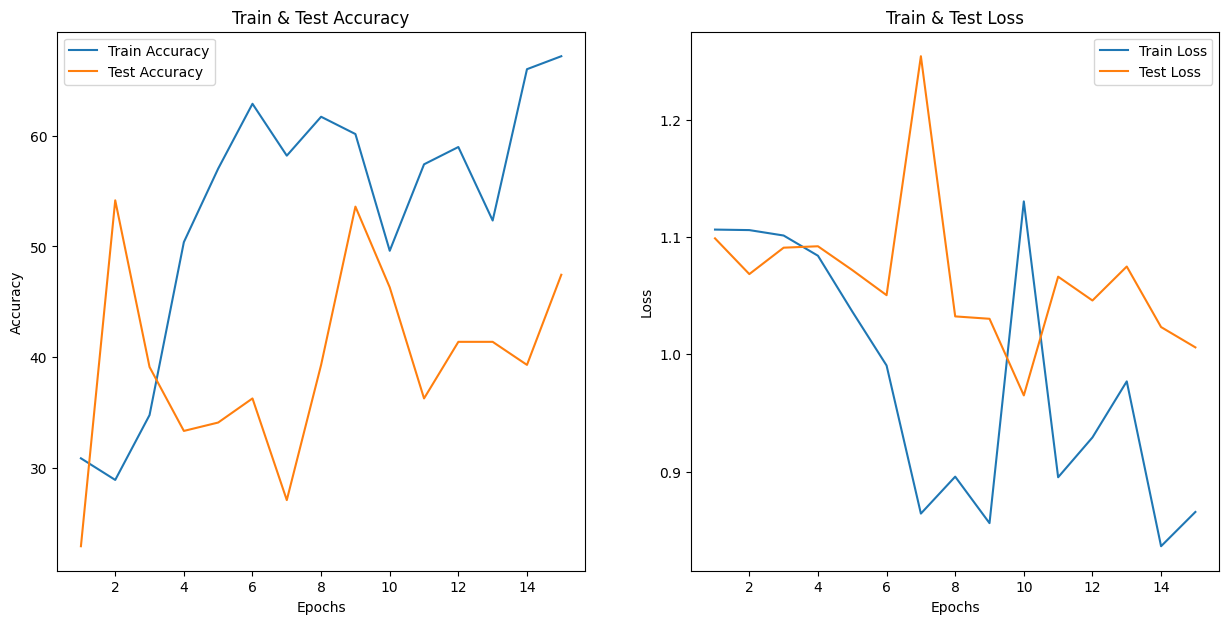

In [24]:
plot_curves(results=convNetsModelV0Result, epochs=EPOCHS)

## 5.1 What Should an Ideal Loss Curve Look Like?
* Loss Curve is one of the most helpful ways to troubleshoot a model
* https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

<img src="https://github.com/uygarkaya/DeepLearning/blob/main/images/LossCurvesForOverfittingUnderfittingIdeal.jpg?raw=true, width=1000">

## 5.1.1 How to Deal with Overfitting
* Since the main problem with [overfitting](https://developers.google.com/machine-learning/glossary#overfitting) is that you're model is fitting the training data too well, you'll want to use techniques to "reign it in"
* A common technique of preventing overfitting is known as [regularization](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html)

<img src="https://github.com/uygarkaya/DeepLearning/blob/main/images/HowToDealOverfitting.png?raw=true, width=600">

## 5.1.2 How to Deal with Underfitting
* When a model is [underfitting](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets
* In essence, an underfitting model will fail to reduce the loss values to a desired level

<img src="https://github.com/uygarkaya/DeepLearning/blob/main/images/HowToDealUnderfitting.png?raw=true, width=600">

## 6. Model 1: TinyVGG with Data Augmentation
*  Let's Try Another Modelling Experiment This Time Using the Same Model as Before with Some Data Augmentation

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create an Instance of TinyVGG
convNetsModelV1 = TinyVGG(
    input_channels=3, # number of color channels in our image data
    input_shape=13*13,
    hidden_neurons=10,
    output_shape=len(class_names)
).to(device)

convNetsModelV1

TinyVGG(
  (first_conv_block): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_conv_block): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [26]:
# Setup Random Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup Hyperparameter
EPOCHS=15
LEARNING_RATE=0.001
MODEL_PARAMETERS=convNetsModelV1.parameters()

# Setup Loss Function & Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=MODEL_PARAMETERS,
                             lr=LEARNING_RATE)

# Start the Timer
execution_start_time = time.time()

# Train First TinyVGG Model
convNetsModelV1Result = train_step(model=convNetsModelV1,
                                   epochs=EPOCHS,
                                   train_data=train_dataloader_augmented,
                                   test_data=test_dataloader_augmented,
                                   loss_func=loss_func,
                                   optimizer=optimizer,
                                   accuracy_func=accuracy_func,
                                   device=device)

# End the Timer & Print Out How Long It Took
execution_end_time = time.time()
model_execution_time = execution_time(
  start_time=execution_start_time,
  end_time=execution_end_time,
  device=device
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train Accuracy: 33.33 | Train Loss: 1.11 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 1 | Train Accuracy: 34.67 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 2 | Train Accuracy: 34.67 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 3 | Train Accuracy: 34.67 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 4 | Train Accuracy: 33.78 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 5 | Train Accuracy: 34.67 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 6 | Train Accuracy: 34.67 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 7 | Train Accuracy: 34.67 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 8 | Train Accuracy: 34.22 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 9 | Train Accuracy: 34.67 | Train Loss: 1.10 | Test Accuracy:  33.33 | Test Loss:  1.10
Epoch: 10 | Train Accuracy: 34.67 | Train Loss: 1.

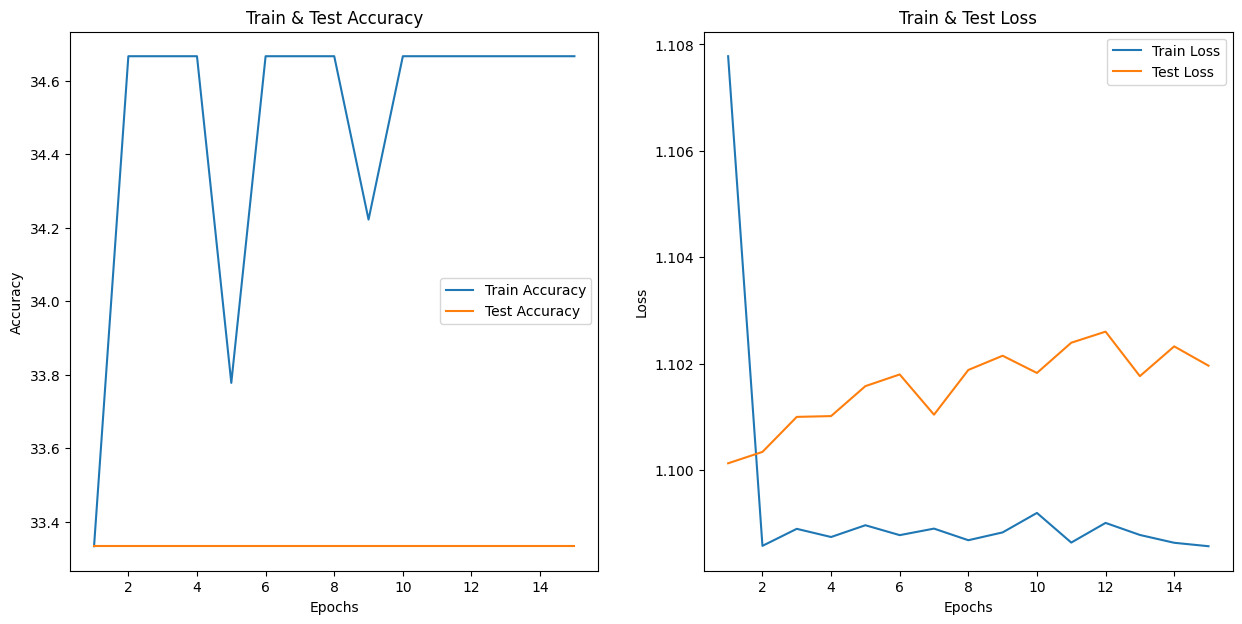

In [27]:
plot_curves(results=convNetsModelV1Result, epochs=EPOCHS)

## 7. Compare Model Results

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [28]:
model0_dataFrame = pd.DataFrame(convNetsModelV0Result)
model1_dataFrame = pd.DataFrame(convNetsModelV1Result)

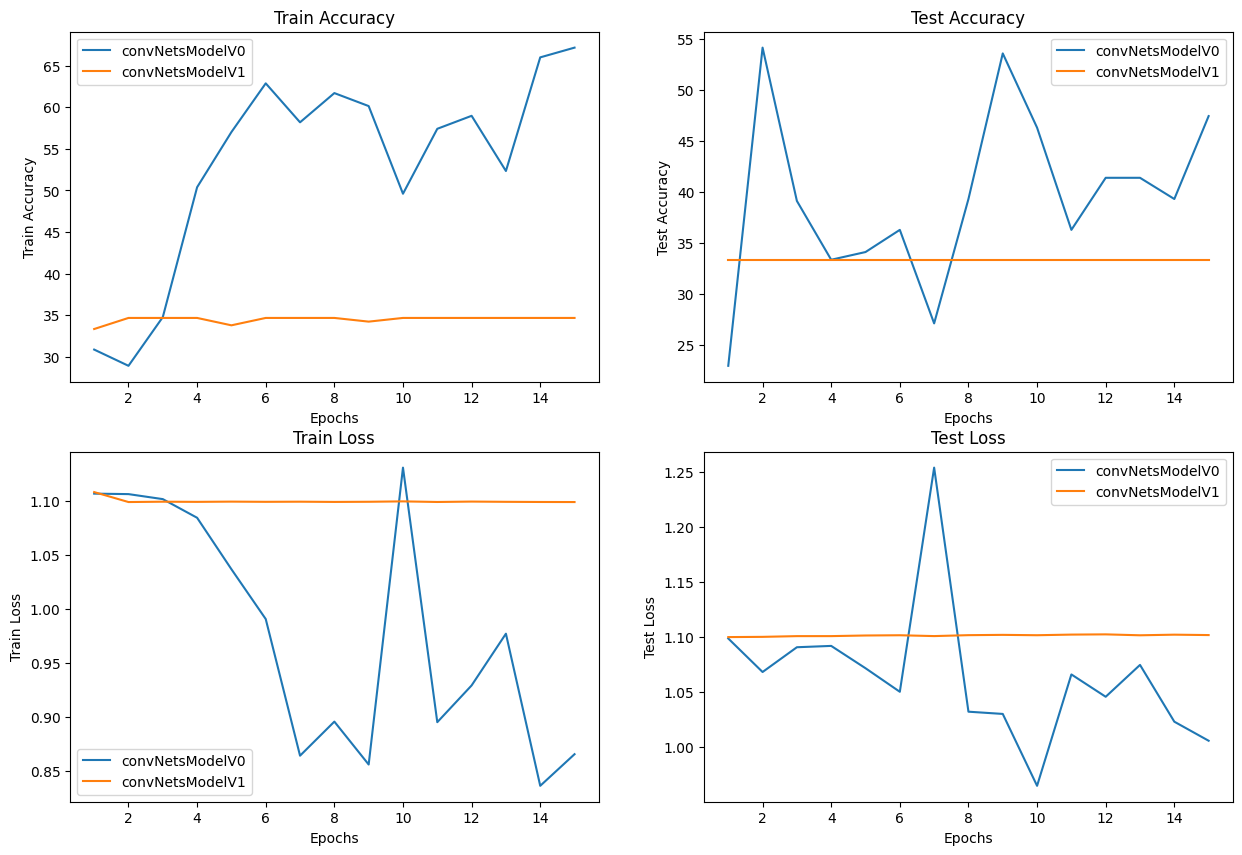

In [29]:
# Generate a List of Epoch Values based on the Number of Epochs
epochs = range(1, EPOCHS + 1)

# Setup a Plot
plt.figure(figsize=(15, 10))

# Plot the Train & Test Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, model0_dataFrame['train_accuracy'], label='convNetsModelV0')
plt.plot(epochs, model1_dataFrame['train_accuracy'], label='convNetsModelV1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model0_dataFrame['test_accuracy'], label='convNetsModelV0')
plt.plot(epochs, model1_dataFrame['test_accuracy'], label='convNetsModelV1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()

# Plot the Train & Test Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, model0_dataFrame['train_loss'], label='convNetsModelV0')
plt.plot(epochs, model1_dataFrame['train_loss'], label='convNetsModelV1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model0_dataFrame['test_loss'], label='convNetsModelV0')
plt.plot(epochs, model1_dataFrame['test_loss'], label='convNetsModelV1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.legend()

## 8. Making Prediction on Custom Image

## 8.1 Loading in Custom Image with PyTorch

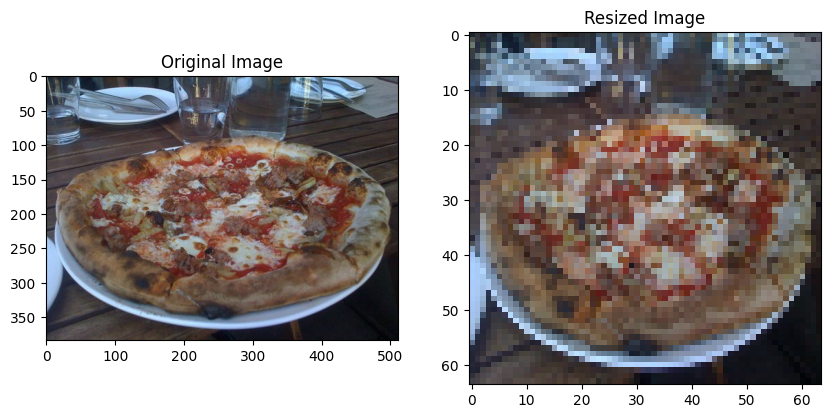

In [49]:
custom_image_path = train_path/"pizza/5764.jpg"
custom_image_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image / 255
custom_image_resize = custom_image_transforms(custom_image) # this will error for eval mode: no batch size

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(custom_image.permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.title('Resized Image')
plt.imshow(custom_image_resize.permute(1, 2, 0))

In [50]:
# To Avoid the Error, Add Batch Size
custom_image_resize = custom_image_resize.unsqueeze(0)

## To Make Prediction on Custom Image We Had To:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model



## 8.2 Putting Custom Image Prediction Together: Building a Function

* Function Where We Pass an Image Path to and Have Our Model Predict on That Image and Plot the Image + Prediction

In [60]:
def make_prediction(model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str] = None,
                    transform=None,
                    device=device):
  """Makes a Prediction on a Target Image with a Trained Model & Plots the Image and Prediction"""

  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Prediction: {class_names[target_image_pred_label.cpu()].capitalize()} | Probability: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Prediction: {target_image_pred_label} | Probability: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)

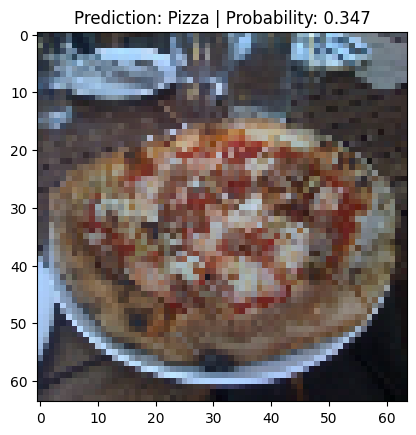

In [61]:
# Pred on Our Custom Image
make_prediction(model=convNetsModelV1,
                image_path=custom_image_path,
                class_names=class_names,
                transform=custom_image_transforms,
                device=device)